<a href="https://colab.research.google.com/github/Jan-Willem/casacore/blob/master/continuum_imaging_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Continuum Imaging 

This notebook will demonstrate how to create a continuum dirty image with natural weighting using ngCASA. The resulting image will be compared with an image created by CASA. 

For this demonstration data from the ALMA First Look at Imaging CASAguide (https://casaguides.nrao.edu/index.php/First_Look_at_Imaging) will be used. The measurement set has been converted to vis.zarr (using convert_ms in cngi.conversion)

This walkthrough is designed to be run in a Jupyter notebook on Google Colaboratory. To open the notebook in colab, go [here](https://colab.research.google.com/github/casangi/cngi_prototype/blob/master/docs/imaging/continuum_imaging_example.ipynb).

## Installation and Dataset Download


In [5]:
import os
os.system("pip install --extra-index-url https://test.pypi.org/simple/ cngi-prototype==0.0.68")

#sis14_twhya_field_5_lsrk_pol_xx.vis.zarr.zip https://drive.google.com/file/d/1PNL0ANqnN7eyYOpQ_vMslQlorUhtrUmE/view?usp=sharing
id = '1PNL0ANqnN7eyYOpQ_vMslQlorUhtrUmE'
os.system('curl -c ./cookie -s -L "https://drive.google.com/uc?export=download&id=%s"' % id)
os.system('curl -Lb ./cookie "https://drive.google.com/uc?export=download&confirm=`awk \'/download/ {print $NF}\' ./cookie`&id=%s" -o vis.zarr.zip' % id)
os.system('unzip vis.zarr.zip')


#casa_twhya_standard_gridder_lsrk_mfs_natural.img.zarr.zip https://drive.google.com/file/d/19VlXp9Qyx60ld0rBSAYMVFTq5Y1KuxO8/view?usp=sharing
id = '19VlXp9Qyx60ld0rBSAYMVFTq5Y1KuxO8'
os.system('curl -c ./cookie -s -L "https://drive.google.com/uc?export=download&id=%s"' % id)
os.system('curl -Lb ./cookie "https://drive.google.com/uc?export=download&confirm=`awk \'/download/ {print $NF}\' ./cookie`&id=%s" -o vis.zarr.zip' % id)
os.system('unzip vis.zarr.zip')

print('complete')

complete


## Load Dataset

Two datasets are are needed for this notebook sis14_twhya_field_5_lsrk_pol_xx.vis.zarr and casa_twhya_standard_gridder_lsrk_mfs_natural.img.zarr (for more information about the img.zarr format go [here](https://cngi-prototype.readthedocs.io/en/latest/visibilities.html) and for the vis.zarr format go [here](https://cngi-prototype.readthedocs.io/en/latest/images.html)). 

The sis14_twhya_field_5_lsrk_pol_xx.vis.zarr dataset is used to create a continuum image. The dataset was created by using the ```mstransform``` command in CASA

```python
mstransform('sis14_twhya_calibrated_flagged.ms',
            outputvis='sis14_twhya_field_5_lsrk_pol_xx.ms', 
            regridms=True, outframe='LSRK', datacolumn='data',
            correlation='XX',field='5')
```

and then convert_ms in cngi.conversion

```python
infile = 'sis14_twhya_field_5_lsrk_pol_xx.ms'
outfile = 'sis14_twhya_field_5_lsrk_pol_xx.vis.zarr'
chunk_shape=(270, 210, 12, 1)
convert_ms(infile, outfile=outfile , chunk_shape=chunk_shape)
```

The conversion to 'LSRK' is necessary because cngi does not currently have an implementation and tclean does a conversion to 'LSRK' before imaging.

To check the ngcasa imaging results the casa_twhya_standard_gridder_lsrk_mfs_natural.img.zarr dataset is used. This dataset was generated by running ```tclean``` in CASA

```python
tclean(vis='sis14_twhya_field_5_lsrk_pol_xx.ms',
       imagename='twhya_standard_gridder_lsrk_mfs_natural',
       specmode='mfs',
       deconvolver='hogbom',
       imsize=[200,400],
       cell=['0.08arcsec'],
       weighting='natural',
       threshold='0mJy',
       niter=0,stokes='XX')
```

and then ```image_ms``` in cngi.conversion

```python
infile = 'twhya_standard_gridder_lsrk_mfs_natural.image'
outfile = 'casa_twhya_standard_gridder_lsrk_mfs_natural.img.zarr'
convert_image(infile=infile,outfile=outfile)
```

In [6]:
import xarray as xr
from cngi.dio import read_vis, read_image

xr.set_options(display_style="html")

mxds = read_vis("sis14_twhya_field_5_lsrk_pol_xx.vis.zarr",chunks={'chan':192})
mxds.xds0

<xarray.Dataset>
Dimensions:         (baseline: 210, chan: 384, pol: 1, pol_id: 1, spw_id: 1, time: 270, uvw_index: 3)
Coordinates:
  * baseline        (baseline) int64 0 1 2 3 4 5 6 ... 204 205 206 207 208 209
  * chan            (chan) float64 3.725e+11 3.725e+11 ... 3.728e+11 3.728e+11
    chan_width      (chan) float64 dask.array<chunksize=(192,), meta=np.ndarray>
    effective_bw    (chan) float64 dask.array<chunksize=(192,), meta=np.ndarray>
  * pol             (pol) int32 9
  * pol_id          (pol_id) int32 0
    resolution      (chan) float64 dask.array<chunksize=(192,), meta=np.ndarray>
  * spw_id          (spw_id) int32 0
  * time            (time) datetime64[ns] 2012-11-19T07:56:26.544000626 ... 2012-11-19T09:07:28.607999802
Dimensions without coordinates: uvw_index
Data variables:
    ANTENNA1        (time, baseline) int32 dask.array<chunksize=(270, 210), meta=np.ndarray>
    ANTENNA2        (time, baseline) int32 dask.array<chunksize=(270, 210), meta=np.ndarray>
    ARRAY_ID        (time, baseline) int32 dask.array<chunksize=(270, 210), meta=np.ndarray>
    DATA            (time, baseline, chan, pol) complex128 dask.array<chunksize=(270, 210, 192, 1), meta=np.ndarray>
    EXPOSURE        (time, baseline) float64 dask.array<chunksize=(270, 210), meta=np.ndarray>
    FEED1           (time, baseline) int32 dask.array<chunksize=(270, 210), meta=np.ndarray>
    FEED2           (time, baseline) int32 dask.array<chunksize=(270, 210), meta=np.ndarray>
    FIELD_ID        (time, baseline) int32 dask.array<chunksize=(270, 210), meta=np.ndarray>
    FLAG            (time, baseline, chan, pol) bool dask.array<chunksize=(270, 210, 192, 1), meta=np.ndarray>
    INTERVAL        (time, baseline) float64 dask.array<chunksize=(270, 210), meta=np.ndarray>
    OBSERVATION_ID  (time, baseline) int32 dask.array<chunksize=(270, 210), meta=np.ndarray>
    PROCESSOR_ID    (time, baseline) int32 dask.array<chunksize=(270, 210), meta=np.ndarray>
    SCAN_NUMBER     (time, baseline) int32 dask.array<chunksize=(270, 210), meta=np.ndarray>
    STATE_ID        (time, baseline) int32 dask.array<chunksize=(270, 210), meta=np.ndarray>
    TIME_CENTROID   (time, baseline) float64 dask.array<chunksize=(270, 210), meta=np.ndarray>
    UVW             (time, baseline, uvw_index) float64 dask.array<chunksize=(270, 210, 3), meta=np.ndarray>
    WEIGHT          (time, baseline, chan, pol) float64 dask.array<chunksize=(270, 210, 192, 1), meta=np.ndarray>
Attributes:
    bbc_no:           2
    corr_product:     [[0, 0]]
    data_groups:      [{'1': {'data': 'DATA', 'flag': 'FLAG', 'id': '1', 'uvw...
    freq_group:       0
    freq_group_name:  
    if_conv_chain:    0
    meas_freq_ref:    1
    name:             ALMA_RB_07#BB_2#SW-01#FULL_RES
    net_sideband:     2
    num_chan:         384
    num_corr:         1
    ref_frequency:    372520022603.63745
    total_bandwidth:  234366781.0546875

Note that the chunks parameter in cngi and ngcasa functions specifies the size of a chunk and not the number of chunks (in CASA ```tclean``` chanchunks refers to the number of channel chunks).

The dimensionality of the sis14_twhya_field_5_lsrk_pol_xx.vis.zarr dataset is (time:270,baseline:210,chan:384,pol:1) and a zarr chunk size of (time:270,baseline:210,chan:12,pol:1) was chosen. With the ```cngi.dio.read_vis``` function the dask chunk size was set to (time:270,baseline:210,chan:192,pol:1). For more information concerning chunking go [here](https://cngi-prototype.readthedocs.io/en/latest/development.html).

## Flag Data and Create Imaging Weights 
The ```apply_flags``` cngi.vis function sets all values that should be flagged to nan. The ngcasa.imaging code does not internally apply flags but does ignore nan values. [apply_flags documentation](https://cngi-prototype.readthedocs.io/en/latest/_api/autoapi/cngi/vis/apply_flags/index.html#cngi.vis.apply_flags.apply_flags)

The ```make_imaging_weight``` cngi.imaging function takes the WEIGHT data variables and creates IMAGING_WEIGHT data variable that has dimensions time x baseline x chan x pol (matches the visibility DATA variable). Weighting schemes that are supported include natural, uniform, briggs, briggs_abs. [make_imaging_weight documentation](https://cngi-prototype.readthedocs.io/en/latest/_api/autoapi/ngcasa/imaging/make_imaging_weight/index.html#ngcasa.imaging.make_imaging_weight.make_imaging_weight)

In [7]:
from cngi.vis import apply_flags
from ngcasa.imaging import make_imaging_weight

mxds = apply_flags(mxds, 'xds0', flags='FLAG')

imaging_weights_parms = {}
imaging_weights_parms['weighting'] = 'natural'

sel_parms = {}
sel_parms['xds'] = 'xds0'
sel_parms['data_group_in_id'] = 1 

grid_parms = {}
grid_parms['chan_mode'] = 'continuum'
grid_parms['image_size'] = [200,400]
grid_parms['cell_size'] = [0.08,0.08]

mxds = make_imaging_weight(mxds, imaging_weights_parms, grid_parms, sel_parms)

mxds.xds0

######################### Start make_imaging_weights #########################
Setting data_group_in  to  {'data': 'DATA', 'flag': 'FLAG', 'id': '1', 'uvw': 'UVW', 'weight': 'WEIGHT'}
Setting default data_group_out  to  {'data': 'DATA', 'flag': 'FLAG', 'id': '1', 'uvw': 'UVW', 'weight': 'WEIGHT', 'imaging_weight': 'IMAGING_WEIGHT'}
Since weighting is natural input weight will be reused as imaging weight.
######################### Created graph for make_imaging_weight #########################


<xarray.Dataset>
Dimensions:         (baseline: 210, chan: 384, pol: 1, pol_id: 1, spw_id: 1, time: 270, uvw_index: 3)
Coordinates:
  * baseline        (baseline) int64 0 1 2 3 4 5 6 ... 204 205 206 207 208 209
  * chan            (chan) float64 3.725e+11 3.725e+11 ... 3.728e+11 3.728e+11
    chan_width      (chan) float64 dask.array<chunksize=(192,), meta=np.ndarray>
    effective_bw    (chan) float64 dask.array<chunksize=(192,), meta=np.ndarray>
  * pol             (pol) int32 9
  * pol_id          (pol_id) int32 0
    resolution      (chan) float64 dask.array<chunksize=(192,), meta=np.ndarray>
  * spw_id          (spw_id) int32 0
  * time            (time) datetime64[ns] 2012-11-19T07:56:26.544000626 ... 2012-11-19T09:07:28.607999802
Dimensions without coordinates: uvw_index
Data variables:
    ANTENNA1        (time, baseline) int32 dask.array<chunksize=(270, 210), meta=np.ndarray>
    ANTENNA2        (time, baseline) int32 dask.array<chunksize=(270, 210), meta=np.ndarray>
    ARRAY_ID        (time, baseline) int32 dask.array<chunksize=(270, 210), meta=np.ndarray>
    DATA            (time, baseline, chan, pol) complex128 dask.array<chunksize=(270, 210, 192, 1), meta=np.ndarray>
    EXPOSURE        (time, baseline) float64 dask.array<chunksize=(270, 210), meta=np.ndarray>
    FEED1           (time, baseline) int32 dask.array<chunksize=(270, 210), meta=np.ndarray>
    FEED2           (time, baseline) int32 dask.array<chunksize=(270, 210), meta=np.ndarray>
    FIELD_ID        (time, baseline) int32 dask.array<chunksize=(270, 210), meta=np.ndarray>
    FLAG            (time, baseline, chan, pol) bool dask.array<chunksize=(270, 210, 192, 1), meta=np.ndarray>
    INTERVAL        (time, baseline) float64 dask.array<chunksize=(270, 210), meta=np.ndarray>
    OBSERVATION_ID  (time, baseline) int32 dask.array<chunksize=(270, 210), meta=np.ndarray>
    PROCESSOR_ID    (time, baseline) int32 dask.array<chunksize=(270, 210), meta=np.ndarray>
    SCAN_NUMBER     (time, baseline) int32 dask.array<chunksize=(270, 210), meta=np.ndarray>
    STATE_ID        (time, baseline) int32 dask.array<chunksize=(270, 210), meta=np.ndarray>
    TIME_CENTROID   (time, baseline) float64 dask.array<chunksize=(270, 210), meta=np.ndarray>
    UVW             (time, baseline, uvw_index) float64 dask.array<chunksize=(270, 210, 3), meta=np.ndarray>
    WEIGHT          (time, baseline, chan, pol) float64 dask.array<chunksize=(270, 210, 192, 1), meta=np.ndarray>
Attributes:
    bbc_no:           2
    corr_product:     [[0, 0]]
    data_groups:      [{'1': {'data': 'DATA', 'flag': 'FLAG', 'id': '1', 'uvw...
    freq_group:       0
    freq_group_name:  
    if_conv_chain:    0
    meas_freq_ref:    1
    name:             ALMA_RB_07#BB_2#SW-01#FULL_RES
    net_sideband:     2
    num_chan:         384
    num_corr:         1
    ref_frequency:    372520022603.63745
    total_bandwidth:  234366781.0546875

## Create Dirty Continuum Image and Primary Beam
The ```make_image``` cngi.imaging function grids the data (using the prolate spheroidal function as an anti-aliasing filter), fast Fourier transform the gridded data to an image and normalizes the image. The ```make_pb``` function currently supports rotationally symmetric airy disk primary beams. The ```write_zarr``` function is now used to trigger a compute (which includes applying the flags, creating the imaging weights and making the image).

[make_pb documentation](https://cngi-prototype.readthedocs.io/en/latest/_api/autoapi/ngcasa/imaging/make_mosaic_pb/index.html#ngcasa.imaging.make_mosaic_pb.make_mosaic_pb)

[make_image documentation](https://cngi-prototype.readthedocs.io/en/latest/_api/autoapi/ngcasa/imaging/make_image/index.html#ngcasa.imaging.make_image.make_imagel)

In [8]:
from ngcasa.imaging import make_image
from ngcasa.imaging import make_pb
from cngi.dio import write_zarr
import dask

grid_parms = {}
grid_parms['chan_mode'] = 'continuum'
grid_parms['image_size'] = [200,400]
grid_parms['cell_size'] = [0.08,0.08]
grid_parms['phase_center'] = mxds.FIELD.PHASE_DIR[0,0,:].data.compute()

vis_sel_parms = {}
vis_sel_parms['xds'] = 'xds0'
vis_sel_parms['data_group_in_id'] = 1

img_sel_parms = {}
img_sel_parms['data_group_out_id'] = 1

img_xds = xr.Dataset() #empty dataset

img_xds = make_image(mxds, img_xds, grid_parms, vis_sel_parms, img_sel_parms)


make_pb_parms = {}
make_pb_parms['function'] = 'alma_airy'
make_pb_parms['list_dish_diameters'] = [10.7]
make_pb_parms['list_blockage_diameters'] = [0.75]

sel_parms = {}
sel_parms['img_description_in_indx'] = 1


img_xds = make_pb(img_xds,make_pb_parms, grid_parms, sel_parms)


img_xds = write_zarr(img_xds, 'twhya_standard_gridder_lsrk_mfs_natural.img.zarr')


######################### Start make_image #########################
Setting default image_center  to  [100 200]
Setting default fft_padding  to  1.2
Setting data_group_in  to  {'data': 'DATA', 'flag': 'FLAG', 'id': '1', 'uvw': 'UVW', 'weight': 'WEIGHT', 'imaging_weight': 'WEIGHT'}
Setting default data_group_out  to  {'data': 'DATA', 'flag': 'FLAG', 'id': '2', 'uvw': 'UVW', 'weight': 'WEIGHT', 'imaging_weight': 'WEIGHT'}
Setting default data_group_in  to  {'id': '1'}
Setting default data_group_out [' sum_weight ']  to  SUM_WEIGHT
Setting default data_group_out [' image ']  to  IMAGE
######################### Created graph for make_image #########################
######################### Start make_pb #########################
Setting default data_group_in  to  {'id': '1', 'sum_weight': 'SUM_WEIGHT', 'image': 'IMAGE'}
Setting default data_group_out  to  {'id': '1', 'sum_weight': 'SUM_WEIGHT', 'image': 'IMAGE', 'pb': 'PB'}
Setting default image_center  to  [100 200]
Setting default fft_

In [9]:
casa_image_dataset = read_image("casa_twhya_standard_gridder_lsrk_mfs_natural.img.zarr")
casa_image_dataset

<xarray.Dataset>
Dimensions:            (chan: 1, l: 200, m: 400, pol: 1, time: 1)
Coordinates:
  * chan               (chan) float64 3.726e+11
    declination        (l, m) float64 dask.array<chunksize=(200, 400), meta=np.ndarray>
  * l                  (l) float64 3.879e-05 3.84e-05 ... -3.801e-05 -3.84e-05
  * m                  (m) float64 -7.757e-05 -7.718e-05 ... 7.679e-05 7.718e-05
  * pol                (pol) float64 9.0
    right_ascension    (l, m) float64 dask.array<chunksize=(200, 400), meta=np.ndarray>
  * time               (time) datetime64[ns] 2012-11-19T07:56:26.544000626
Data variables:
    IMAGE              (l, m, time, chan, pol) float64 dask.array<chunksize=(200, 400, 1, 1, 1), meta=np.ndarray>
    IMAGE_MASK0        (l, m, time, chan, pol) bool dask.array<chunksize=(200, 400, 1, 1, 1), meta=np.ndarray>
    IMAGE_PBCOR        (l, m, time, chan, pol) float64 dask.array<chunksize=(200, 400, 1, 1, 1), meta=np.ndarray>
    IMAGE_PBCOR_MASK0  (l, m, time, chan, pol) bool dask.array<chunksize=(200, 400, 1, 1, 1), meta=np.ndarray>
    MODEL              (l, m, time, chan, pol) float64 dask.array<chunksize=(200, 400, 1, 1, 1), meta=np.ndarray>
    PB                 (l, m, time, chan, pol) float64 dask.array<chunksize=(200, 400, 1, 1, 1), meta=np.ndarray>
    PB_MASK0           (l, m, time, chan, pol) bool dask.array<chunksize=(200, 400, 1, 1, 1), meta=np.ndarray>
    PSF                (l, m, time, chan, pol) float64 dask.array<chunksize=(200, 400, 1, 1, 1), meta=np.ndarray>
    RESIDUAL           (l, m, time, chan, pol) float64 dask.array<chunksize=(200, 400, 1, 1, 1), meta=np.ndarray>
    RESIDUAL_MASK0     (l, m, time, chan, pol) bool dask.array<chunksize=(200, 400, 1, 1, 1), meta=np.ndarray>
    SUMWT              (time, chan, pol) float64 dask.array<chunksize=(1, 1, 1), meta=np.ndarray>
Attributes:
    axisnames:            ['Right Ascension', 'Declination', 'Time', 'Frequen...
    axisunits:            ['rad', 'rad', 'datetime64[ns]', 'Hz', '']
    commonbeam:           [0.6637904644012451, 0.5050938129425049, -65.900085...
    commonbeam_units:     ['arcsec', 'arcsec', 'deg']
    date_observation:     2012/11/19/07
    direction_reference:  j2000
    imagetype:            Intensity
    incr:                 [-3.878509448876288e-07, 3.878509448876288e-07, 1.0...
    object_name:          tw hya
    observer:             cqi
    pointing_center:      11
    rest_frequency:       3.72637e+11 hz
    restoring_beam:       0.66379 arcsec, 0.505094 arcsec, -65.9001 deg
    restoringbeam:        [0.6637904644012451, 0.5050938129425049, -65.900085...
    spectral__reference:  lsrk
    telescope:            alma
    telescope_position:   [2.22514e+06m, -5.44031e+06m, -2.48103e+06m] (itrf)
    unit:                 Jy/beam
    velocity__type:       radio

## Plot and Compare With CASA

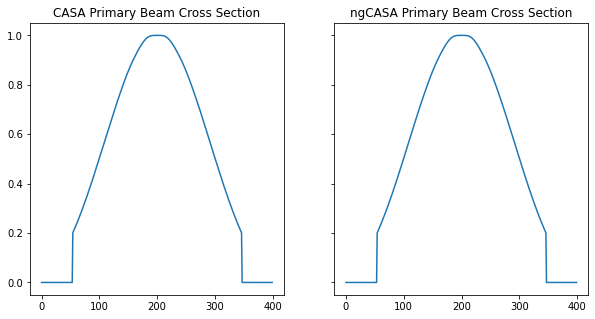

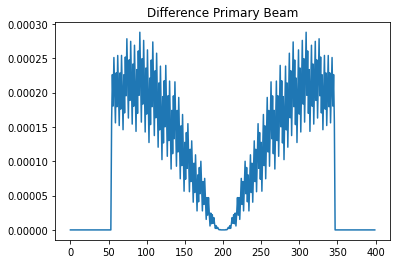

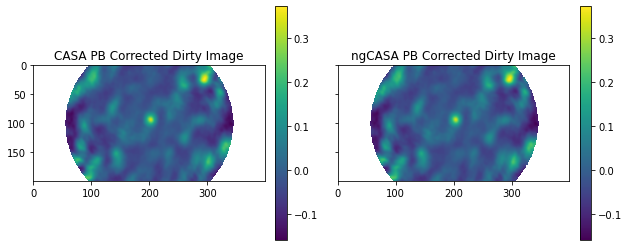

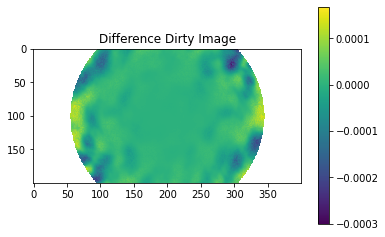

Max Normalized Error 0.0005571487508716499
RMS Normalized Error 0.01138875657799844


In [11]:
import matplotlib.pylab as plt
import numpy as np
import xarray as xr
import dask.array as da
import dask
from cngi.dio import read_image

image_dataset = read_image("twhya_standard_gridder_lsrk_mfs_natural.img.zarr")
casa_image_dataset = read_image("casa_twhya_standard_gridder_lsrk_mfs_natural.img.zarr")

#### Primary Beam Corrected Images ####
pb_limit = 0.2
primary_beam = image_dataset.PB[100,:,0,0,0,0].where(image_dataset.PB[100,:,0,0,0,0] > pb_limit,other=0.0)
dirty_image_pb_cor = image_dataset.IMAGE[:,:,0,0,0]/image_dataset.PB[:,:,0,0,0,0]
dirty_image_pb_cor = dirty_image_pb_cor.where(image_dataset.PB[:,:,0,0,0,0] > pb_limit,other=np.nan)

#print(casa_image_dataset)
casa_primary_beam = casa_image_dataset['PB'][100, :,0, 0, 0].data #Primary beam created by CASA
casa_dirty_image_pb_cor = (casa_image_dataset['IMAGE_PBCOR'][:, :,0, 0, 0]).where(casa_image_dataset['PB'][:, :,0, 0, 0] > pb_limit,other=np.nan).data #Image created by CASA

#Plot Primary Beams
fig0, ax0, = plt.subplots(1, 2, sharey=True,figsize=(10, 5))
im0 = ax0[0].plot(casa_primary_beam)
im1 = ax0[1].plot(primary_beam)
ax0[0].title.set_text('CASA Primary Beam Cross Section')
ax0[1].title.set_text('ngCASA Primary Beam Cross Section')
plt.show()

plt.figure()
plt.plot(casa_primary_beam-primary_beam)
plt.title('Difference Primary Beam')
plt.show()

#Plotting Images
fig0, ax0 = plt.subplots(1, 2, sharey=True,figsize=(10, 5))
im0 = ax0[0].imshow(casa_dirty_image_pb_cor)
im1 = ax0[1].imshow(dirty_image_pb_cor)
ax0[0].title.set_text('CASA PB Corrected Dirty Image')
ax0[1].title.set_text('ngCASA PB Corrected Dirty Image')
fig0.colorbar(im0, ax=ax0[0], fraction=0.046, pad=0.04)
fig0.colorbar(im1, ax=ax0[1], fraction=0.046, pad=0.04)
plt.show()
 
plt.figure()
plt.imshow(casa_dirty_image_pb_cor - dirty_image_pb_cor)
plt.title('Difference Dirty Image')
plt.colorbar()
plt.show()

dirty_image_pb_cor = dirty_image_pb_cor / np.nanmax(np.abs(dirty_image_pb_cor))
casa_dirty_image_pb_cor = casa_dirty_image_pb_cor / np.nanmax(np.abs(casa_dirty_image_pb_cor))
norm_diff_image_pb_cor = dirty_image_pb_cor - casa_dirty_image_pb_cor

# Calculate max error
max_error_dirty_image = np.nanmax(np.abs(norm_diff_image_pb_cor))
print('Max Normalized Error',max_error_dirty_image)

# Calculate root mean square error
rms_error_dirty_image = np.sqrt(np.nansum(np.square(norm_diff_image_pb_cor)))
print('RMS Normalized Error',rms_error_dirty_image)



The difference in primary beam is due to CASA using a sampled 1D function while ngCASA calculates the PB for each pixel. If it is found that PB creation becomes a bottleneck for ngCASA the implementation will be changed to match CASA.